# Introduction

**In this notebook, I would like to describe a baseline for medical image object detection using PyTorch.**

I am a physician and I am studying AI and data science. I am working on public health, such as health screening. These days face masks play a great role in public health and preventive medicine to prevent infection among general people.

This time we try machine learning to detect face masks using PyTorch. **XML file is frequently used for medical image object detection.**

# Install and Import Necessary Libraries

First, we install and import necessary libraries.

In [1]:
!pip install -q albumentations==0.5.2
import albumentations as A
A.__version__

'0.5.2'

In [2]:
import torch
torch.__version__

'1.11.0'

In [3]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [4]:
import torchvision
torchvision.__version__

'0.12.0'

In [5]:
!pip install -q pytorch_lightning
import pytorch_lightning as pl
print(pl.__version__)

1.9.0


# Create Dataset with Data Augmentation for Training

The given code defines **a custom dataset class** called MaskDataset for a face mask detection task. This dataset is designed to work with PyTorch.

Here is a breakdown of the code:

1. The __init__ method initializes the dataset object and sets the root directory for the dataset. It also **defines a list of mask labels**, which includes 'BG' (background), 'without_mask', 'with_mask', and 'mask_weared_incorrect'. It creates a sorted list of image filenames in the root directory.

2. The transform variable defines a series of data augmentation transformations using the Albumentations library. These transformations include **horizontal and vertical flips, random brightness and contrast adjustments, and conversion to tensors**.

3. The __getitem__ method is responsible for loading and preprocessing a single data sample. It takes an index (idx) as input and returns the corresponding image and target data.

   a. It **constructs the image path and loads the image using PIL (Image.open), converting it to RGB format**.

   b. It **constructs the annotation path and parses the XML annotation file using an XML parser**.

   c. It iterates over the objects in the annotation file and extracts the bounding box coordinates (boxes) and corresponding labels (labels). **The labels are converted to numerical indices** based on their position in the mask_labels list.

   d. It applies **the defined transformations (self.transform) to the image and bounding boxes using Albumentations**. The transformed image, boxes, and labels are returned.

   e. Additionally, it calculates **the area of each bounding box** and creates **tensors for image_id and iscrowd (used for estimating mean Average Precision)**.

4. The __len__ method returns **the total number of images** in the dataset.

In [6]:
import os
import numpy as np
from PIL import Image
from torchvision import transforms
from xml.etree.ElementTree import parse
from albumentations.pytorch import ToTensor

In [7]:
class MaskDataset(torch.utils.data.Dataset):

    def __init__(self, root):
        self.root = root
        self.mask_labels = ['BG', 'without_mask', 'with_mask', 'mask_weared_incorrect']
        self.imgs = list(sorted(os.listdir('/kaggle/input/face-mask-detection/images/')))
        # Add for data augmentation.
        bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels'])
        self.transform = A.Compose([
            A.HorizontalFlip(p = 0.1),
            A.VerticalFlip(p = 0.1),
            A.RandomBrightnessContrast(p = 0.1),
            ToTensor()
          ], bbox_params = bbox_params)

    def __getitem__(self, idx):
        data = 'maksssksksss' + str(idx)

        image_path = f'{self.root}/images/{data}.png'
        image = Image.open(image_path).convert('RGB')
        image = np.array(image)

        anno_path = f'{self.root}/annotations/{data}.xml'
        parser = parse(anno_path)
        labels, boxes = [], []
        for obj in parser.findall('object'):
            bndbox = obj.find('bndbox')
            if bndbox.find('xmin').text != bndbox.find('xmax').text: # Add
                box = [int(tag.text) for tag in obj.find('bndbox')]
                label = obj.find('name').text
                label = self.mask_labels.index(label)
                boxes.append(box)
                labels.append(label)
                
        transformed = self.transform(image = image, bboxes = boxes, class_labels = labels)
        image = transformed['image']
        boxes = torch.tensor(transformed['bboxes'], dtype = torch.float32)
        labels = torch.tensor(transformed['class_labels'], dtype = torch.int64)
        
        # Add for estimation of mean Average Precisions.
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        image_id = torch.tensor([idx])
        iscrowd = torch.zeros((len(parser.findall('object')),), dtype = torch.int64)

        target = {'boxes': boxes, 'labels': labels, 'image_id': image_id, 'area': area, 'iscrowd': iscrowd}

        return image, target


    def __len__(self):
        return len(self.imgs)

We create and check the dataset.

In [8]:
pl.seed_everything(0)
root = '/kaggle/input/face-mask-detection'
dataset1 = MaskDataset(root)

In [9]:
len(dataset1)

853

In [10]:
x, t = dataset1[0]

In [11]:
x

tensor([[[0.4431, 0.4314, 0.3843,  ..., 0.1569, 0.2824, 0.3373],
         [0.4118, 0.3882, 0.3451,  ..., 0.1529, 0.1882, 0.3098],
         [0.3765, 0.3569, 0.3255,  ..., 0.1490, 0.1216, 0.2784],
         ...,
         [0.3333, 0.3412, 0.3569,  ..., 0.1098, 0.1098, 0.1137],
         [0.3373, 0.3490, 0.3608,  ..., 0.1137, 0.1137, 0.1176],
         [0.3647, 0.3765, 0.3922,  ..., 0.1176, 0.1176, 0.1216]],

        [[0.4353, 0.4235, 0.3765,  ..., 0.2314, 0.3843, 0.4549],
         [0.3922, 0.3804, 0.3373,  ..., 0.2275, 0.2863, 0.4275],
         [0.3608, 0.3412, 0.3098,  ..., 0.2235, 0.2235, 0.3922],
         ...,
         [0.3255, 0.3333, 0.3490,  ..., 0.1059, 0.1059, 0.1098],
         [0.3294, 0.3412, 0.3529,  ..., 0.1098, 0.1098, 0.1137],
         [0.3569, 0.3686, 0.3843,  ..., 0.1137, 0.1137, 0.1176]],

        [[0.4549, 0.4431, 0.3961,  ..., 0.4000, 0.6157, 0.7294],
         [0.4157, 0.3922, 0.3490,  ..., 0.3843, 0.5059, 0.6784],
         [0.3647, 0.3451, 0.3137,  ..., 0.3529, 0.4118, 0.

In [12]:
type(x), x.dtype, x.shape

(torch.Tensor, torch.float32, torch.Size([3, 366, 512]))

In [13]:
t

{'boxes': tensor([[ 79., 105., 109., 142.],
         [185., 100., 226., 144.],
         [325.,  90., 360., 141.]]),
 'labels': tensor([1, 2, 1]),
 'image_id': tensor([0]),
 'area': tensor([1110., 1804., 1785.]),
 'iscrowd': tensor([0, 0, 0])}

## Some data have become improper because of data augmentation. They must be removed from the training dataset.

In [14]:
x.shape[2]

512

In [15]:
t['boxes'][0][2].item()

109.0

In [16]:
len(t['boxes'])

3

In [17]:
for i in range(len(t['boxes'])):
    if x.shape[2] < t['boxes'][i][2]:
        print(x.shape)
        print(t)
    else:
        print('No problem.')

No problem.
No problem.
No problem.


The code you provided runs a loop over the length of dataset1 and tries to retrieve each item using the __getitem__ method of the MaskDataset class. **If an exception occurs during the retrieval of an item, it catches the exception and prints an error message indicating the index where the error occurred.**

In [18]:
for i in range(len(dataset1)):
    try:
        x, t = dataset1[i]
    except Exception as e:
        print(f"Error at {i}.")

Error at 5.
Error at 93.
Error at 110.
Error at 231.
Error at 251.
Error at 457.
Error at 501.
Error at 603.
Error at 616.
Error at 706.
Error at 787.


In [19]:
for i in range(len(dataset1)):
    try:
        x, t = dataset1[i]
    except Exception as e:
        print(f"{i},")

5,
93,
110,
231,
251,
457,
501,
603,
616,
706,
787,


In [20]:
removed_list = [5,
93,
110,
231,
251,
457,
501,
603,
616,
706,
787]

In this code below, a new list called dataset is created. The loop iterates over the indices of dataset1, and **if the index i is found in the removed_list, the loop moves to the next iteration using the pass statement**. **Otherwise, it appends the corresponding item from dataset1 to the dataset list.**

By the end of the loop, dataset will **contain all the items from dataset1 except for those with indices specified in the removed_list**.

In [21]:
dataset = []
for i in range(len(dataset1)):
    if i in removed_list:
        pass
    else:
        dataset.append(dataset1[i])

In [22]:
len(dataset)

842

In [23]:
for i in range(len(dataset)):
    try:
        x, t = dataset[i]
    except Exception as e:
        print(f"Error at {i}.")

In [24]:
dataset1 = dataset

In [25]:
for i in range(len(dataset1)):
    try:
        x, t = dataset1[i]
    except Exception as e:
        print(f"Error at {i}.")

# Visualize Sample Data

This code below defines a function called visualize_boxes that takes an image tensor x and its corresponding target dictionary t as inputs. The function visualizes the bounding boxes and labels on the image.

Here's a breakdown of the code:

1. The mask_labels list contains the labels for different mask classes.

2. **The image tensor x is converted to a NumPy array** (x.permute(1, 2, 0).numpy()) and then **to a PIL Image object** (Image.fromarray(...)). The image tensor is expected to have dimensions (channels, height, width).

3. **The bounding boxes (t['boxes']) and labels (t['labels']) are** retrieved from the target dictionary t and **converted to NumPy arrays**.

4. The PIL Image object is used to **create a drawing object** (ImageDraw.Draw(image)).

5. The function uses a specified font (NotoSansCJKjp-Bold.otf) to draw the labels on the image. The font size is set to 6.

6. For each bounding box and label pair, the function **draws a red rectangle** around the box and **fills a red rectangle with the label text** at the top left corner of the box.

7. Finally, the function returns the modified image with the bounding boxes and labels drawn on it.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont

In [27]:
%%capture
!if [ ! -d fonts ]; then mkdir fonts && cd fonts && wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip && unzip NotoSansCJKjp-hinted.zip && cd .. ;fi

In [28]:
def visualize_boxes(x, t):

    mask_labels = ['BG', 'without_mask', 'with_mask', 'mask_weared_incorrect']

    image = x.permute(1, 2, 0).numpy()
    image = Image.fromarray((image * 255).astype(np.uint8))

    boxes = t['boxes'].cpu().detach().numpy()
    labels = t['labels'].cpu().detach().numpy()

    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype('fonts/NotoSansCJKjp-Bold.otf', 6)
    for box, label in zip(boxes, labels):
        # box
        draw.rectangle(box, outline = 'red')
        # label
        text = mask_labels[label]
        w, h = font.getsize(text)
        draw.rectangle([box[0], box[1], box[0] + w, box[1] + h], fill = 'red')
        draw.text((box[0], box[1]), text, font = font, fill = 'white')

    return image

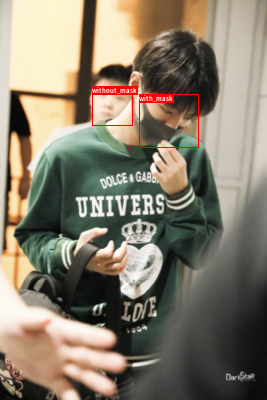

In [29]:
visualize_boxes(x, t)

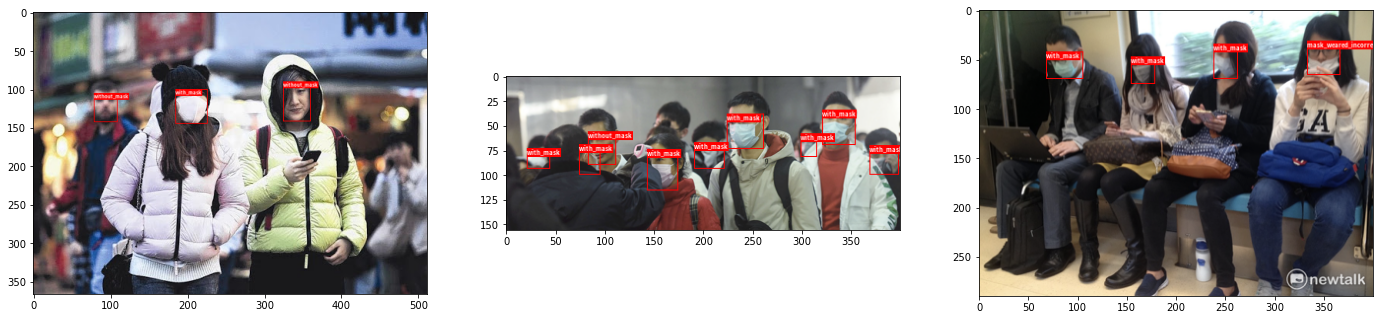

In [30]:
plt.figure(figsize = (24, 12))
for i in range(3):
    x, t = dataset1[i]
    image = visualize_boxes(x, t)
    plt.subplot(1, 3, i + 1)
    plt.imshow(image)

The random_split() function returns three Subset objects: train1, val1, and test1. These subsets can be used as separate datasets for training, validation, and testing, respectively.

In [31]:
train1, val1, test1 = torch.utils.data.random_split(dataset = dataset1, lengths = [752, 40, 50], generator = torch.Generator().manual_seed(4))

In [32]:
len(train1), len(val1), len(test1)

(752, 40, 50)

**The collate_fn function takes a batch as input, which is a list of samples.** It uses the zip(batch) expression to transpose the batch of samples. This results in a list of tuples, where **each tuple contains the elements from the corresponding positions in the samples**. 

In [33]:
def collate_fn(batch):
    return list(zip(* batch))

batch_size = 8

train_loader = torch.utils.data.DataLoader(train1, batch_size, shuffle = False, drop_last = True, collate_fn = collate_fn)

The code creates a DataLoader object called train_loader using the torch.utils.data.DataLoader class. It takes the following arguments:

    train1: The dataset to be loaded (train1 in this case).

    batch_size: The batch size, which is set to 8.

    shuffle: A boolean value indicating whether to shuffle the samples. It is set to False, so the samples will not be shuffled.

    drop_last: A boolean value indicating whether to drop the last incomplete batch if its size is less than batch_size. It is set to True, so the last incomplete batch will be dropped.

    collate_fn: The collate function to be used to merge samples into batches. In this case, the custom collate_fn function is provided.

**The train_loader object can be used in training loops to iterate over batches of data from the train1 dataset.** Each iteration will provide a batch of samples, where each sample is a tuple containing the elements from the corresponding positions in the original samples.

In [34]:
x, t = next(iter(train_loader))

In [35]:
x

(tensor([[[0.3922, 0.3843, 0.3961,  ..., 0.5922, 0.5922, 0.5843],
          [0.4039, 0.3922, 0.4078,  ..., 0.5922, 0.5882, 0.5843],
          [0.4078, 0.4000, 0.4000,  ..., 0.5882, 0.5882, 0.5765],
          ...,
          [0.0549, 0.0275, 0.0275,  ..., 0.3686, 0.3608, 0.3569],
          [0.0549, 0.0235, 0.0235,  ..., 0.3725, 0.3686, 0.3490],
          [0.0863, 0.0549, 0.0588,  ..., 0.3922, 0.3725, 0.3647]],
 
         [[0.3647, 0.3608, 0.3686,  ..., 0.5961, 0.5961, 0.5882],
          [0.3765, 0.3686, 0.3804,  ..., 0.5961, 0.5922, 0.5882],
          [0.3843, 0.3725, 0.3765,  ..., 0.5922, 0.5922, 0.5804],
          ...,
          [0.0627, 0.0353, 0.0353,  ..., 0.3804, 0.3725, 0.3686],
          [0.0627, 0.0314, 0.0314,  ..., 0.3843, 0.3804, 0.3608],
          [0.0902, 0.0588, 0.0627,  ..., 0.4000, 0.3843, 0.3804]],
 
         [[0.3176, 0.3176, 0.3255,  ..., 0.6196, 0.6196, 0.6078],
          [0.3333, 0.3216, 0.3333,  ..., 0.6157, 0.6157, 0.6118],
          [0.3412, 0.3255, 0.3294,  ...,

In [36]:
len(x)

8

In [37]:
t

({'boxes': tensor([[156.,  54., 254., 163.],
          [ 35., 170.,  90., 223.],
          [234.,  17., 294.,  96.]]),
  'labels': tensor([2, 2, 1]),
  'image_id': tensor([349]),
  'area': tensor([10682.,  2915.,  4740.]),
  'iscrowd': tensor([0, 0, 0])},
 {'boxes': tensor([[148., 130., 176., 161.],
          [233., 126., 261., 155.],
          [ 43., 138.,  62., 160.],
          [108., 115., 131., 137.],
          [288., 116., 303., 138.],
          [318., 133., 336., 151.],
          [365., 129., 382., 148.],
          [188., 132., 199., 147.]]),
  'labels': tensor([2, 2, 1, 1, 1, 1, 1, 1]),
  'image_id': tensor([570]),
  'area': tensor([868., 812., 418., 506., 330., 324., 323., 165.]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0])},
 {'boxes': tensor([[295.,  75., 334., 115.],
          [198.,  91., 223., 116.],
          [225.,  65., 248.,  90.],
          [119.,  85., 149., 115.]]),
  'labels': tensor([2, 2, 2, 2]),
  'image_id': tensor([278]),
  'area': tensor([1560.,  625.,  575

In [38]:
type(x)

tuple

# Create Dataset without Data Augmentation for Validation and Test

This process is **the same as above except for data augmentation**, because validation and test data must be created without data augmentation. **It is also possible to create a train dataset without data augmentation. In this case this code is used for all the datasets.**

In [39]:
class MaskDataset(torch.utils.data.Dataset):

    def __init__(self, root):
        self.root = root
        self.mask_labels = ['BG', 'without_mask', 'with_mask', 'mask_weared_incorrect']
        self.imgs = list(sorted(os.listdir('/kaggle/input/face-mask-detection/images/')))
        # Add for data augmentation.
        bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels'])
        self.transform = A.Compose([ToTensor()], bbox_params = bbox_params)
    

    def __getitem__(self, idx):
        data = 'maksssksksss' + str(idx)

        image_path = f'{self.root}/images/{data}.png'
        image = Image.open(image_path).convert('RGB')
        image = np.array(image)

        anno_path = f'{self.root}/annotations/{data}.xml'
        parser = parse(anno_path)
        labels, boxes = [], []
        for obj in parser.findall('object'):
            bndbox = obj.find('bndbox') # Add
            if bndbox.find('xmin').text != bndbox.find('xmax').text: # Add
                box = [int(tag.text) for tag in obj.find('bndbox')]
                label = obj.find('name').text
                label = self.mask_labels.index(label)
                boxes.append(box)
                labels.append(label)
                
        transformed = self.transform(image = image, bboxes = boxes, class_labels = labels)
        image = transformed['image']
        boxes = torch.tensor(transformed['bboxes'], dtype = torch.float32)
        labels = torch.tensor(transformed['class_labels'], dtype = torch.int64)
        
        # Add for estimation of mean Average Precisions.
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        image_id = torch.tensor([idx])
        iscrowd = torch.zeros((len(parser.findall('object')),), dtype = torch.int64)

        target = {'boxes': boxes, 'labels': labels, 'image_id': image_id, 'area': area, 'iscrowd': iscrowd}

        return image, target


    def __len__(self):
        return len(self.imgs)

In [40]:
pl.seed_everything(0)
root = '/kaggle/input/face-mask-detection'
dataset2 = MaskDataset(root)

In [41]:
dataset = []
removed = []
for i in range(len(dataset2)):
    if i in removed_list:
        removed.append(dataset2[i])
    else:
        dataset.append(dataset2[i])

In [42]:
len(dataset)

842

In [43]:
dataset2 = dataset

In [44]:
train2, val2, test2 = torch.utils.data.random_split(dataset = dataset2, lengths = [752, 40, 50], generator = torch.Generator().manual_seed(42))

In [45]:
len(train2), len(val2), len(test2)

(752, 40, 50)

## The removed data can be used for validation or test.

**The data is proper because data augmentation is not conducted for validation and test datasets.**

In [46]:
val = []
for i in range(len(val2)):
    val.append(val2[i])
for i in range(len(removed)):
    val.append(removed[i])
len(val)

51

In [47]:
val2 = val
len(val2)

51

In [48]:
def collate_fn(batch):
    return list(zip(* batch))

batch_size = 8

val_loader = torch.utils.data.DataLoader(val2, batch_size, collate_fn = collate_fn)
test_loader = torch.utils.data.DataLoader(test2, batch_size, collate_fn = collate_fn)

# Training, Validation, and Test with RetinaNet

The code provided below defines **a PyTorch Lightning module** called Net for training and evaluating **a RetinaNet model for object detection**.

Here's a breakdown of the code:

1. The Net class inherits from pl.LightningModule, which is the base class for all PyTorch Lightning modules.

2. The __init__ method initializes the Net class and defines the model architecture. It loads **a pre-trained RetinaNet model (retinanet_resnet50_fpn)** and **modifies the classification head to have n_class output classes**. **It also initializes the classification logits layer (cls_logits) and sets the weights and biases using appropriate initialization methods.**

3. The forward method defines the forward pass of the model. During training, it takes input x and target t and passes them through the model. During evaluation, it only takes the input x and passes it through the model.

4. The training_step method is called during training and computes the loss for a batch of data (x and t). **It logs the training loss (train_loss) and returns the loss value.**

5. The validation_step method is called during validation and computes the loss for a batch of data (x and t). **It logs the validation loss (val_loss).**

6. The test_step method is called during testing and computes the loss for a batch of data (x and t). **It logs the test loss (test_loss).**

7. The configure_optimizers method is responsible for configuring the optimizer used for training. It creates **an Adam optimizer** and selects the parameters that require gradients from the model.

To use this module with PyTorch Lightning, we would typically create an instance of the Net class and pass it to a Trainer for training and evaluation.

In [49]:
import math
from torchvision.models.detection import retinanet_resnet50_fpn

In [50]:
class Net(pl.LightningModule):

    def __init__(self, n_class = 4):
        super().__init__()

        self.model = retinanet_resnet50_fpn(pretrained = True)
        self.num_anchors = self.model.head.classification_head.num_anchors

        self.model.head.classification_head.num_classes = n_class

        self.cls_logits = torch.nn.Conv2d(256, self.num_anchors * n_class, kernel_size = 3, stride = 1, padding = 1)
        torch.nn.init.normal_(self.cls_logits.weight, std = 0.01)  # RetinaNetClassificationHead
        torch.nn.init.constant_(self.cls_logits.bias, - math.log((1 - 0.01) / 0.01))  # RetinaNetClassificationHead
        self.model.head.classification_head.cls_logits = self.cls_logits

        for p in self.model.parameters():
            p.requires_grad = False

        for p in self.model.head.classification_head.parameters():
            p.requires_grad = True

        for p in self.model.head.regression_head.parameters():
            p.requires_grad = True

        self.model.cuda()

    def forward(self, x, t = None):
        if self.training:
            return self.model(x, t)
        else:
            return self.model(x)


    def training_step(self, batch, batch_idx):
        x, t = batch
        losses = self(x, t)
        loss = sum(losses.values())
        self.log('train_loss', loss, on_step = True, on_epoch = True, prog_bar = True)
        return loss


    def validation_step(self, batch, batch_idx):
        x, t = batch
        losses = self.train().forward(x, t)
        loss = sum(losses.values())
        self.log('val_loss', loss, on_step = False, on_epoch = True)


    def test_step(self, batch, batch_idx):
        x, t = batch
        losses = self.train().forward(x, t)
        loss = sum(losses.values())
        self.log('test_loss', loss, on_step = False, on_epoch = True)


    def configure_optimizers(self):
        params = [p for p in self.model.parameters() if p.requires_grad]
        optimizer = torch.optim.Adam(params)
        return optimizer

The provided code sets the random seed, creates an instance of the Net class, and initializes a Trainer for training and evaluation using PyTorch Lightning.

Here's the breakdown of the code:

1. The pl.seed_everything(0) sets the random seed to 0 for reproducibility.

2. The Net() creates an instance of the Net class that you defined earlier.

3. The pl.Trainer() initializes a Trainer object for training and evaluation. It takes several arguments:

   max_epochs: The maximum number of training epochs, set to 20 in this case.
   
   gpus: The number of GPUs to use for training. 1 indicates using a single GPU.
   
   deterministic: A boolean value indicating whether to enforce deterministic behavior for operations, such as convolution, to ensure reproducibility.

4. The trainer.fit(net, train_loader, val_loader) **starts the training process using the fit() method** of the Trainer object. It takes the following arguments:

   net: The model to train, which is the Net instance.
   
   train_loader: The DataLoader for the training data.
   
   val_loader: The DataLoader for the validation data.

By running this code, **the model net will be trained for 20 epochs using the provided training and validation data loaders.** The Trainer object handles the training loop, including batching, optimization, and logging.

In [51]:
pl.seed_everything(0) # Set the random seed.
net = Net() # Create an instance of the Net class.
trainer = pl.Trainer(max_epochs = 30, gpus = 1, deterministic = True) # Initialize the Trainer.
trainer.fit(net, train_loader, val_loader) # Start the training process.

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth


  0%|          | 0.00/130M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:468: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/data.py:85: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [52]:
trainer.test(dataloaders = test_loader)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:128: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  + f" You can pass `.{fn}(ckpt_path='best')` to use the best model or"


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.24774610996246338    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.24774610996246338}]

In [53]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

# Visualize the Results

The provided code defines a function called visualize_results that **takes an input image tensor and the output of an object detection model as inputs**. The function **visualizes the predicted bounding boxes and labels on the input image**.

Here's a breakdown of the code:

1. The mask_labels list contains the labels for different mask classes.

2. The input image tensor (input) is converted to a NumPy array (input.permute(1, 2, 0).numpy()) and then to a PIL Image object (Image.fromarray(...)). The input image tensor is expected to have dimensions (channels, height, width).

3. The bounding boxes (output['boxes']) and labels (output['labels']) are retrieved from the output dictionary of the object detection model and converted to NumPy arrays.

4. If the output dictionary contains 'scores' (indicating confidence scores for the detections), **the bounding boxes and labels are filtered based on a threshold of 0.5**.

5. A drawing object (ImageDraw.Draw(image)) is created from the PIL Image object, and a font (NotoSansCJKjp-Bold.otf) is defined.

6. For each bounding box and label pair, the function draws a red rectangle around the box and fills a red rectangle with the label text at the top left corner of the box.

7. Finally, the modified image with the bounding boxes and labels drawn on it is returned.

**To use this function, we can pass an input image tensor and the output of the object detection model to visualize the predicted bounding boxes and labels on the image.**

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont

In [55]:
%%capture
!if [ ! -d fonts ]; then mkdir fonts && cd fonts && wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip && unzip NotoSansCJKjp-hinted.zip && cd .. ;fi

In [56]:
def visualize_results(input, output):

    mask_labels = ['BG', 'without_mask', 'with_mask', 'mask_weared_incorrect']

    image = input.permute(1, 2, 0).numpy()
    image = Image.fromarray((image * 255).astype(np.uint8))

    boxes = output['boxes'].cpu().detach().numpy()
    labels = output['labels'].cpu().detach().numpy()

    if 'scores' in output.keys():
        scores = output['scores'].cpu().detach().numpy()
        boxes = boxes[scores > 0.5]
        labels = labels[scores > 0.5]

    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype('fonts/NotoSansCJKjp-Bold.otf', 6)
    for box, label in zip(boxes, labels):
        # box
        draw.rectangle(box, outline = 'red')
        # label
        text = mask_labels[label]
        w, h = font.getsize(text)
        draw.rectangle([box[0], box[1], box[0] + w, box[1] + h], fill = 'red')
        draw.text((box[0], box[1]), text, font = font, fill = 'white')

    return image

In [57]:
net.cpu().eval()
x, t = test2[0]
y = net(x.unsqueeze(0))[0]

In [58]:
x

tensor([[[0.2314, 0.1529, 0.0784,  ..., 0.3804, 0.3804, 0.3647],
         [0.2000, 0.1137, 0.0980,  ..., 0.3686, 0.3765, 0.3725],
         [0.1725, 0.0902, 0.1020,  ..., 0.3725, 0.3843, 0.3804],
         ...,
         [0.1333, 0.1490, 0.1490,  ..., 0.5373, 0.5373, 0.5294],
         [0.1255, 0.1490, 0.1529,  ..., 0.5333, 0.5333, 0.5294],
         [0.1176, 0.1333, 0.1412,  ..., 0.5333, 0.5333, 0.5294]],

        [[0.3216, 0.2196, 0.1608,  ..., 0.4510, 0.4510, 0.4431],
         [0.3020, 0.2118, 0.1490,  ..., 0.4392, 0.4549, 0.4549],
         [0.2863, 0.1804, 0.1451,  ..., 0.4510, 0.4667, 0.4627],
         ...,
         [0.2314, 0.2549, 0.2588,  ..., 0.5922, 0.5922, 0.5843],
         [0.2275, 0.2471, 0.2588,  ..., 0.5961, 0.5961, 0.5922],
         [0.2078, 0.2314, 0.2431,  ..., 0.5961, 0.5961, 0.5922]],

        [[0.2941, 0.2118, 0.1490,  ..., 0.4078, 0.4196, 0.4118],
         [0.2784, 0.1882, 0.1490,  ..., 0.3961, 0.4196, 0.4235],
         [0.2627, 0.1647, 0.1451,  ..., 0.4078, 0.4275, 0.

In [59]:
t

{'boxes': tensor([[124.,  48., 143.,  96.],
         [201.,  89., 235., 121.],
         [226.,  15., 271.,  66.]]),
 'labels': tensor([1, 1, 2]),
 'image_id': tensor([189]),
 'area': tensor([ 912., 1088., 2295.]),
 'iscrowd': tensor([0, 0, 0])}

In [60]:
y

{'boxes': tensor([[226.1118,  17.3620, 269.2892,  66.5555],
         [201.0158,  88.9513, 234.6549, 121.0230],
         [124.2045,  47.0426, 145.1713,  95.3137],
         [114.4832,  58.2895, 143.4047,  97.8244],
         [ 75.8850,  44.4483, 129.3458, 112.7762],
         [100.6646,  58.0832, 136.7989, 102.9120],
         [205.9393,  95.1638, 243.1403, 130.2132],
         [ 72.3771,  44.3871, 125.6155, 117.5693],
         [200.9669,  81.0204, 228.0082, 110.3597],
         [ 75.8850,  44.4483, 129.3458, 112.7762],
         [201.4152,  89.0555, 234.0442, 121.9482],
         [205.6564,  86.6995, 238.7630, 124.4925],
         [ 94.5896, 103.0149, 147.6160, 144.3067],
         [211.4213,  91.5111, 234.4597, 114.7681],
         [200.0715,  91.6106, 214.7206, 110.6948]], grad_fn=<StackBackward0>),
 'scores': tensor([0.9984, 0.9713, 0.7953, 0.2171, 0.0969, 0.0924, 0.0901, 0.0843, 0.0755,
         0.0709, 0.0639, 0.0607, 0.0591, 0.0570, 0.0552],
        grad_fn=<IndexBackward0>),
 'labels': ten

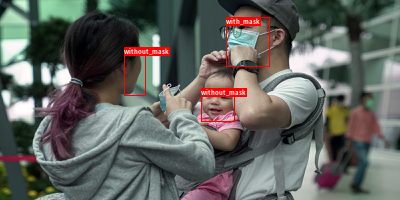

In [61]:
visualize_results(x, y)

In [62]:
x, t = test2[1]
y = net(x.unsqueeze(0))[0]

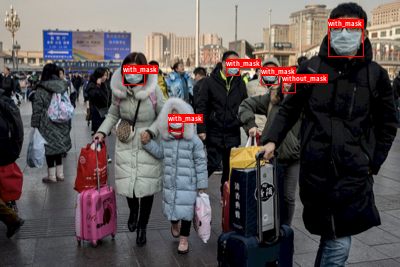

In [63]:
visualize_results(x, y)

# Non-Maximum Suppression (NMS) to Select the Best Boxes

The provided code below uses the net (instance of the Net class) to perform object detection on three test samples from test2. It then applies **non-maximum suppression (NMS) to filter out overlapping bounding boxes and visualizes the results** using the visualize_results function.

Here's a breakdown of the code:

1. The plt.figure(figsize=(24, 12)) sets the figure size for the visualization.

2. net.eval() sets the model to **evaluation mode, disabling any layers such as dropout or batch normalization that behave differently during training and evaluation**.

3. **The loop iterates three times, where each iteration processes a different test sample.**

4. x, t = test2[i] retrieves the input image (x) and target (t) for the current iteration from test2.

5. y = net(x.unsqueeze(0))[0] **performs object detection on the input image by passing it through the net model**. The unsqueeze(0) is used to add a batch dimension to the input image tensor.

6. keep = batched_nms(boxes=y['boxes'], scores=y['scores'], idxs=y['labels'], iou_threshold=0.2) **applies NMS using the batched_nms function to filter out overlapping bounding boxes based on their scores and labels**.

7. y_nms = {'boxes': y['boxes'][keep], 'labels': y['labels'][keep], 'scores': y['scores'][keep]} **creates a new dictionary (y_nms) containing the filtered bounding boxes, labels, and scores**.

8. image = visualize_results(x, y_nms) **visualizes the filtered results by calling the visualize_results function** with the input image tensor (x) and the filtered dictionary of results (y_nms).

9. plt.subplot(1, 3, i + 1) **sets up a subplot to display the current image** in the appropriate position.

10. plt.imshow(image) displays the image in the subplot.

**By running this code, we will generate a figure with three subplots, each showing the input image with the predicted bounding boxes and labels after applying NMS.**

In [64]:
from torchvision.ops import batched_nms

In [65]:
keep = batched_nms(boxes = y['boxes'], scores = y['scores'], idxs = y['labels'], iou_threshold = 0.2)
keep

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 11, 14, 15, 16, 18, 19, 21, 23, 24])

In [66]:
y['boxes'][keep]

tensor([[328.8264,  19.9726, 363.4979,  56.1969],
        [123.4547,  65.9584, 144.3588,  84.5148],
        [226.8899,  59.5674, 239.5123,  75.2738],
        [261.4297,  67.1042, 278.1060,  84.1587],
        [282.8170,  74.4122, 295.1852,  92.5018],
        [168.8352, 114.2585, 183.8982, 131.0323],
        [168.6009, 111.6223, 183.9847, 130.4207],
        [194.2687,  72.2445, 203.9472,  83.2085],
        [177.6745,  66.4365, 185.3684,  74.8945],
        [282.4596,  74.2139, 295.6391,  92.5338],
        [259.8734,  65.8093, 278.7317,  85.1157],
        [218.1234,  62.2850, 225.1119,  73.5608],
        [223.0382,  58.4739, 239.5006,  77.1108],
        [240.0144,  74.7408, 248.4853,  83.9018],
        [178.3667,  67.0686, 185.2458,  76.0116],
        [261.8734,  67.6698, 277.7889,  83.8795],
        [194.6819,  75.7882, 203.1030,  86.8508],
        [177.6745,  66.4365, 185.3684,  74.8945]], grad_fn=<IndexBackward0>)

In [67]:
y['scores'][keep]

tensor([0.9999, 0.9994, 0.9989, 0.9807, 0.6781, 0.6028, 0.2747, 0.2050, 0.1893,
        0.1338, 0.0720, 0.0708, 0.0697, 0.0640, 0.0629, 0.0598, 0.0556, 0.0552],
       grad_fn=<IndexBackward0>)

In [68]:
y['labels'][keep]

tensor([2, 2, 2, 2, 1, 2, 3, 1, 1, 3, 1, 1, 3, 2, 2, 3, 2, 3])

In [69]:
y_nms = {'boxes': y['boxes'][keep], 'labels': y['labels'][keep], 'scores': y['scores'][keep]}
y_nms

{'boxes': tensor([[328.8264,  19.9726, 363.4979,  56.1969],
         [123.4547,  65.9584, 144.3588,  84.5148],
         [226.8899,  59.5674, 239.5123,  75.2738],
         [261.4297,  67.1042, 278.1060,  84.1587],
         [282.8170,  74.4122, 295.1852,  92.5018],
         [168.8352, 114.2585, 183.8982, 131.0323],
         [168.6009, 111.6223, 183.9847, 130.4207],
         [194.2687,  72.2445, 203.9472,  83.2085],
         [177.6745,  66.4365, 185.3684,  74.8945],
         [282.4596,  74.2139, 295.6391,  92.5338],
         [259.8734,  65.8093, 278.7317,  85.1157],
         [218.1234,  62.2850, 225.1119,  73.5608],
         [223.0382,  58.4739, 239.5006,  77.1108],
         [240.0144,  74.7408, 248.4853,  83.9018],
         [178.3667,  67.0686, 185.2458,  76.0116],
         [261.8734,  67.6698, 277.7889,  83.8795],
         [194.6819,  75.7882, 203.1030,  86.8508],
         [177.6745,  66.4365, 185.3684,  74.8945]], grad_fn=<IndexBackward0>),
 'labels': tensor([2, 2, 2, 2, 1, 2, 3, 1, 1,

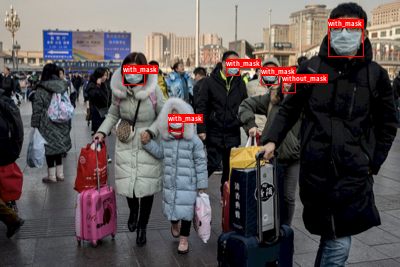

In [70]:
visualize_results(x, y_nms)

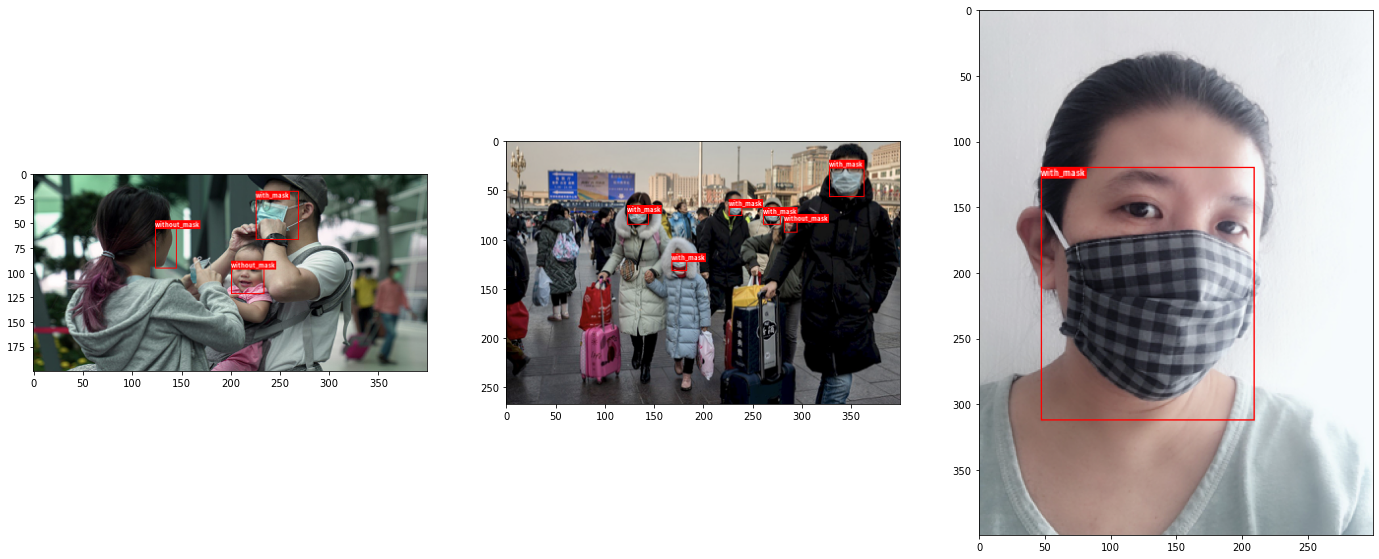

In [71]:
plt.figure(figsize = (24, 12))
net.eval()
for i in range(3):
    x, t = test2[i]
    y = net(x.unsqueeze(0))[0]
    keep = batched_nms(boxes = y['boxes'], scores = y['scores'], idxs = y['labels'], iou_threshold = 0.2)
    y_nms = {'boxes': y['boxes'][keep], 'labels': y['labels'][keep], 'scores': y['scores'][keep]}
    image = visualize_results(x, y_nms)
    plt.subplot(1, 3, i + 1)
    plt.imshow(image)

# Save the Model

Save the trained model to use it later for this or another notebook.

In [72]:
torch.save(net.model, 'object_detection_facemask_pred_model.pth')

In [73]:
saved_model = torch.load('/kaggle/working/object_detection_facemask_pred_model.pth')

In [74]:
saved_model

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


# Conclusion

The results appear to be sufficient to detect face masks properly. Face mask detection is not such a difficult task. It is expected that this AI can be practically used without human workload to check whether people properly wear a face mask or not.

It is also expected that object detection can be used for different medical images to detect various medical findings.

I am a medical doctor working on **artificial intelligence (AI) for medicine**. At present AI is also widely used in the medical field. Particularly, AI performs in the healthcare sector following tasks: **image classification, object detection, semantic segmentation, GANs, text classification, etc**. **If you are interested in AI for medicine, please see my other notebooks.**